# Documentation

**Author:** Anirudh  
**Date:** 10/05/2025

### Details:
- **Modeling:** Using interaction models to capture the influence of sleep over cognitive tests and mri brain volumes, controlling for sociodemographic features.
  - The formula is : "cognitive_function" ~ C(group) * age + C(gender) + C(race) + C(ethnicity) + C(apoe4)" where group is the interaction term (sleep variable)

In [49]:
import statsmodels.formula.api as smf
from collections import defaultdict
import statsmodels.api as sm
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import numpy as np 
import seaborn as sns 

In [2]:
volumes_data = pd.read_csv("Updated_merge.csv")
sleep_data = pd.read_csv("Updated_sleep.csv")
bmi = pd.read_csv("Updated_BMI.csv")

In [3]:
volumes_data = pd.merge(volumes_data, bmi, on='RID')

In [4]:
merge = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [5]:
merge = merge.drop(['MHDESC'], axis=1)

In [7]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_outcomes = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
                'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [8]:
model1_preds = ['Adjusted_Age', 'PTEDUCAT',
                'PTETHCAT',
                'PTGENDER',
                'PTMARRY',
                'PTRACCAT',
                'DX_1',
                'DX_2',
                'ICV']
model2_preds = ['APOE4', 'BMI', 'MH19OTHR',
                'MH2NEURL',
                'MH4CARD',
                'MH5RESP',
                'MHPSYCH',
                ] + model1_preds

In [11]:
interaction_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

In [13]:
model_counter = 1

In [14]:
def save_interaction_results(result, outcome, sleep_var, interaction_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Interaction_Variable': interaction_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
            'F-Statistic': result.fvalue,
            'P-Value (F)': result.f_pvalue,
            'Type': domain
        })
    return records

In [18]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes + sleep_vars +
    mri_outcomes + ['BMI', 'Adjusted_Age', 'ICV']
)
merge_scaled = merge.copy()
scaler = StandardScaler()

merge_scaled[continuous_vars] = scaler.fit_transform(
    merge_scaled[continuous_vars])

In [19]:
categorical_vars = ['DX']
merge_scaled = pd.get_dummies(
    merge_scaled, columns=categorical_vars, drop_first=True)

In [58]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT': 'Ethnicity',
    'PTMARRY': 'Marital Status',
    'APOE4': 'APOE4',
    'BMI': 'BMI',
    'MH19OTHR': 'Other_MH',
    'MH2NEURL': 'Neurological',
    'MH4CARD': 'Cardiovascular',
    'MH5RESP': 'Respiratory',
    'MHPSYCH': 'Psychiatric'
}

In [21]:
def fit_interaction_model(outcomes, domain):
    global model_counter
    for sleep_var in sleep_vars:
        for interaction_var in model2_preds:
            for outcome in outcomes:
                try:
                    formula = f"{outcome} ~ {sleep_var} * {interaction_var} + {' + '.join(model1_preds)}"
                    model = smf.ols(formula, data=merge_scaled).fit()
                    anova_results = anova_lm(model)

                    results = save_interaction_results(
                        model, outcome, sleep_var, interaction_var, domain)
                    interaction_results[domain][sleep_var].extend(results)
                    model_counter += 1
                except Exception as e:
                    print(
                        f"[Error] {domain} model for {outcome} with {sleep_var} and {interaction_var}: {e}")

In [22]:
fit_interaction_model(cognitive_outcomes, 'cognitive')
fit_interaction_model(mri_outcomes, 'mri')

In [23]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/interaction_cognitive_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(interaction_results['cognitive'][sleep_var], f)
    with open(f"Models/interaction_mri_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(interaction_results['mri'][sleep_var], f)

In [24]:
def flatten_interaction_results(results_dict, outcome_type):
    records = []
    for sleep_var, models in results_dict.items():
        for model in models:
            record = {
                'Sleep_Variable': sleep_var,
                'Outcome': model.get('Outcome'),
                'Interaction': model.get('Interaction'),
                'Coefficient': model.get('Coefficient'),
                'P-Value': model.get('P-Value'),
                'Type': outcome_type
            }
            records.append(record)
    return pd.DataFrame(records)

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


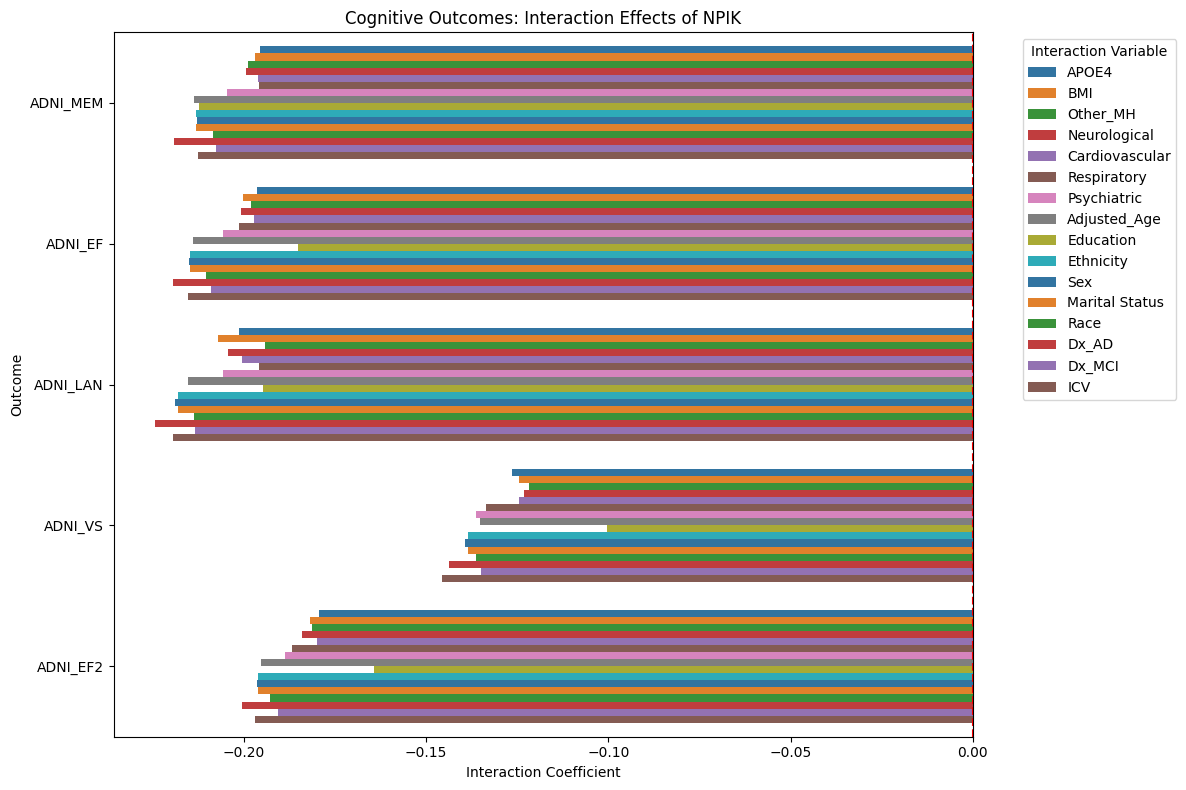

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


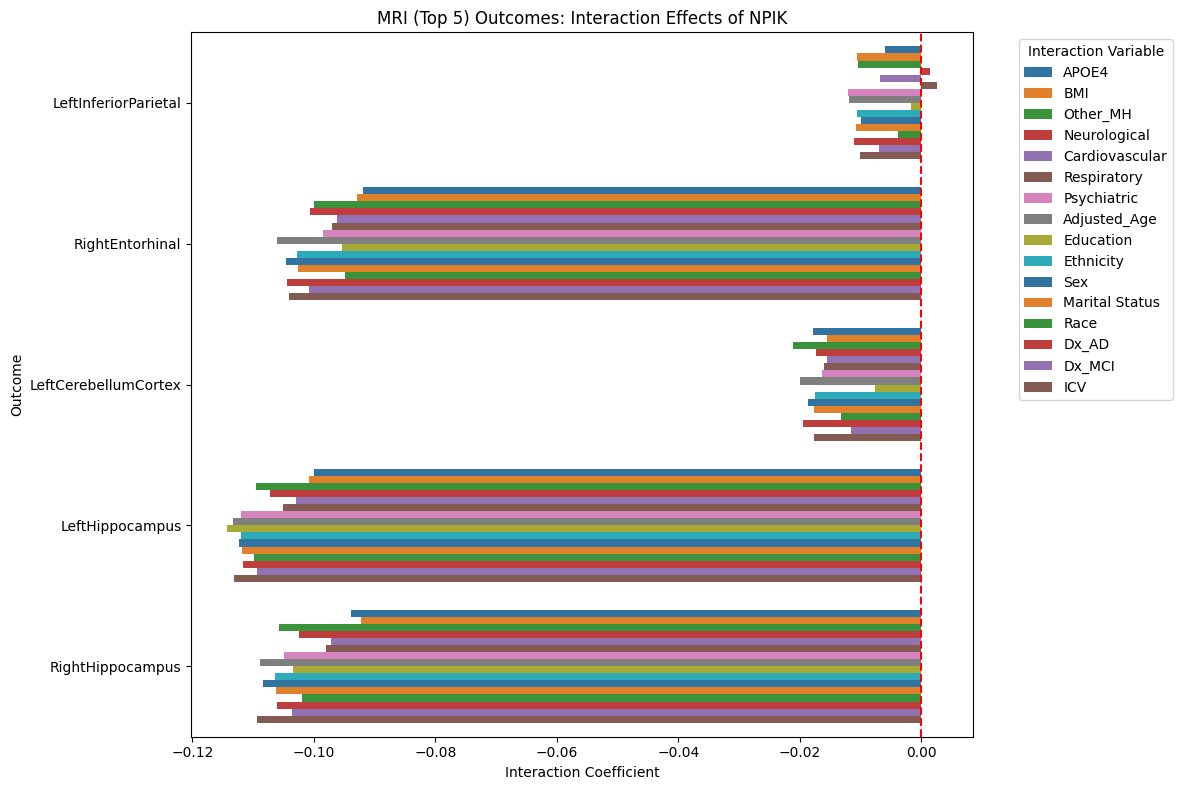

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


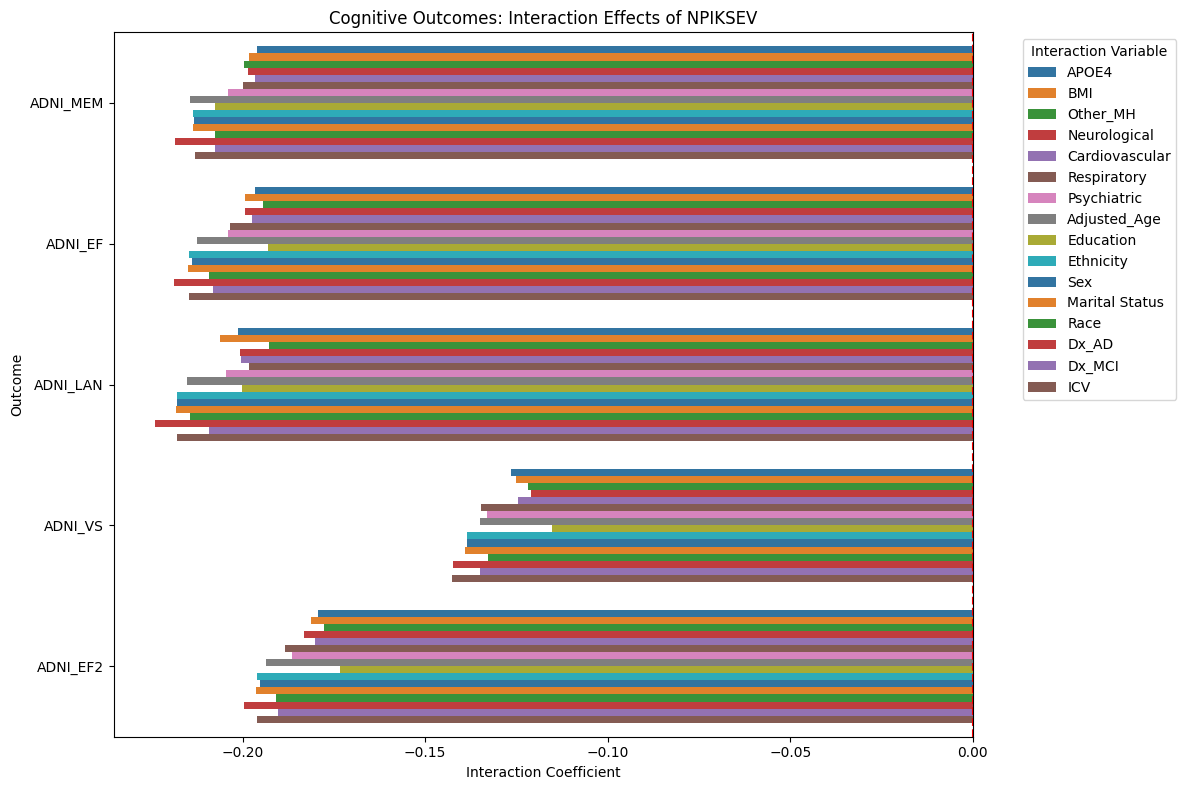

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


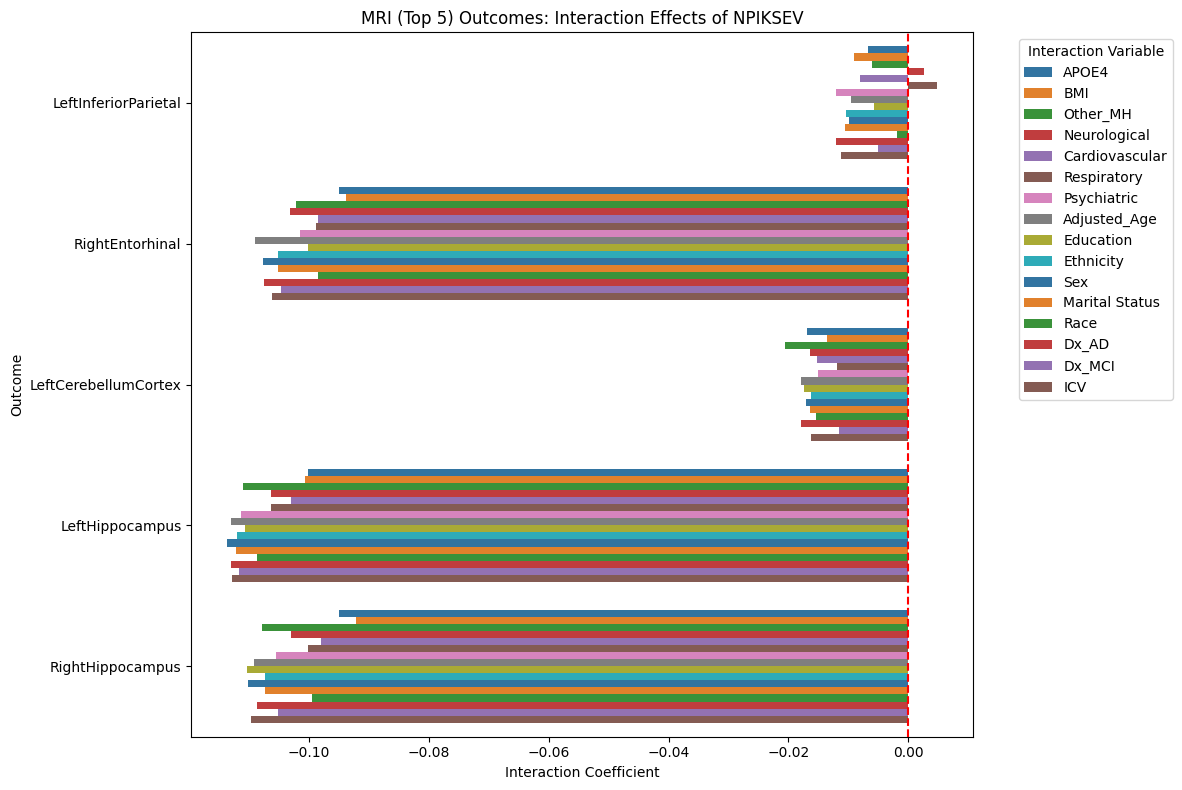

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


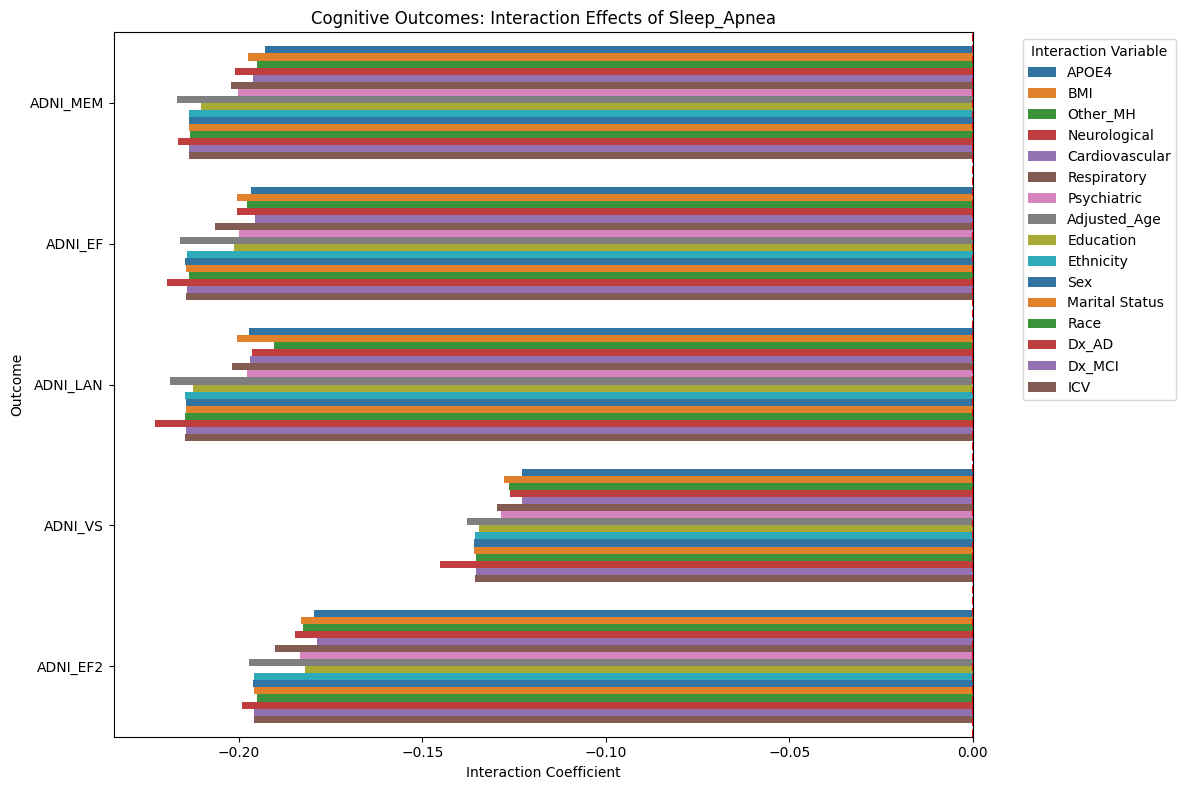

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


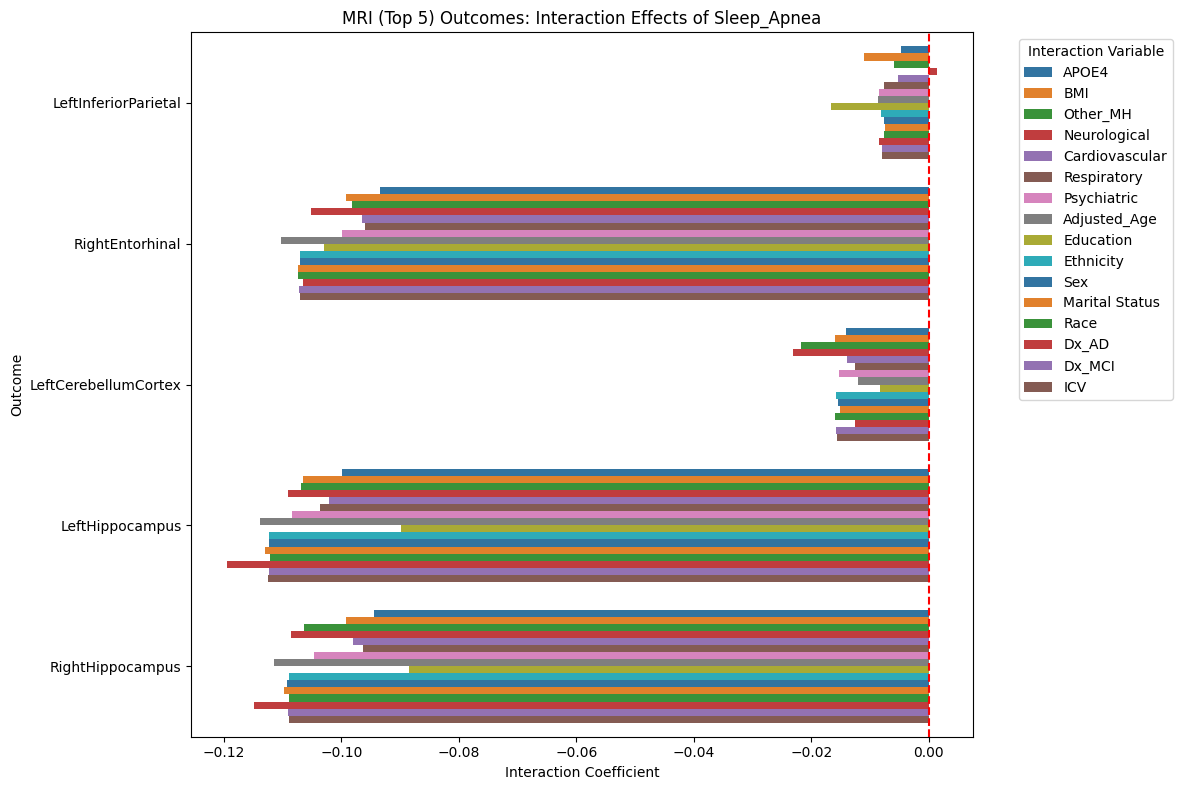

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


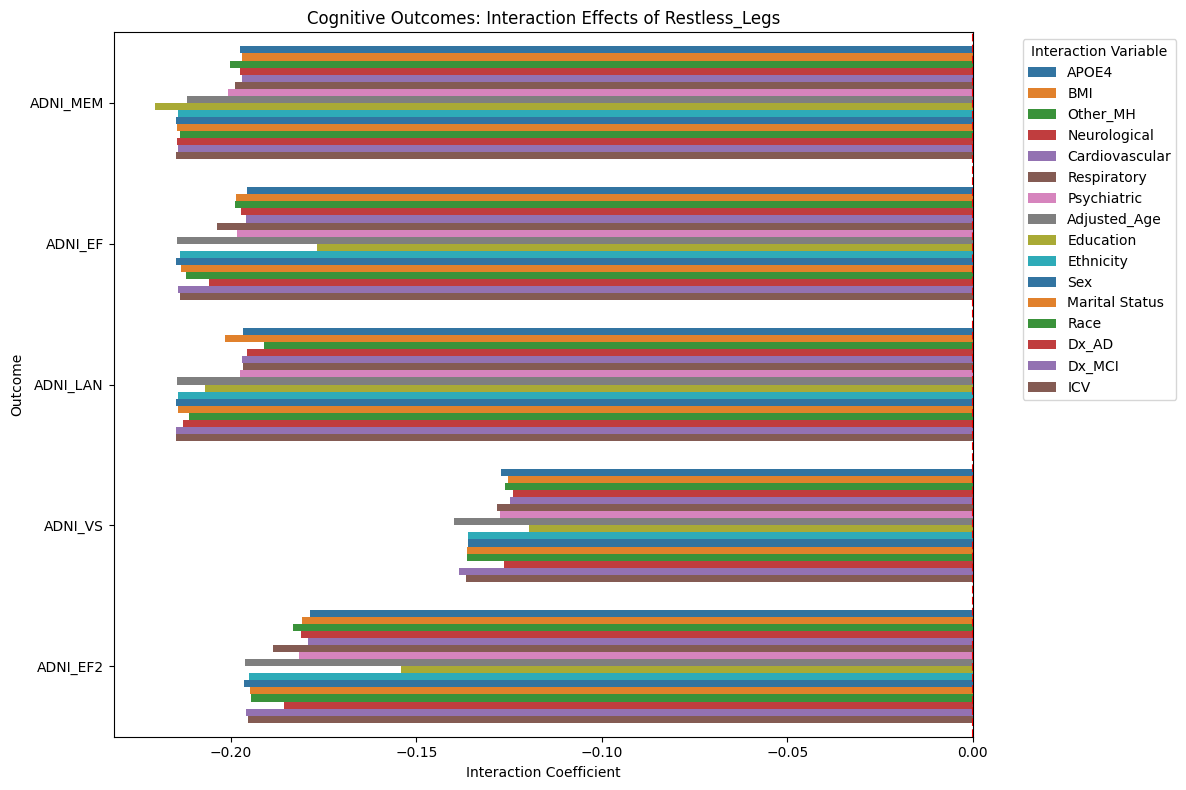

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


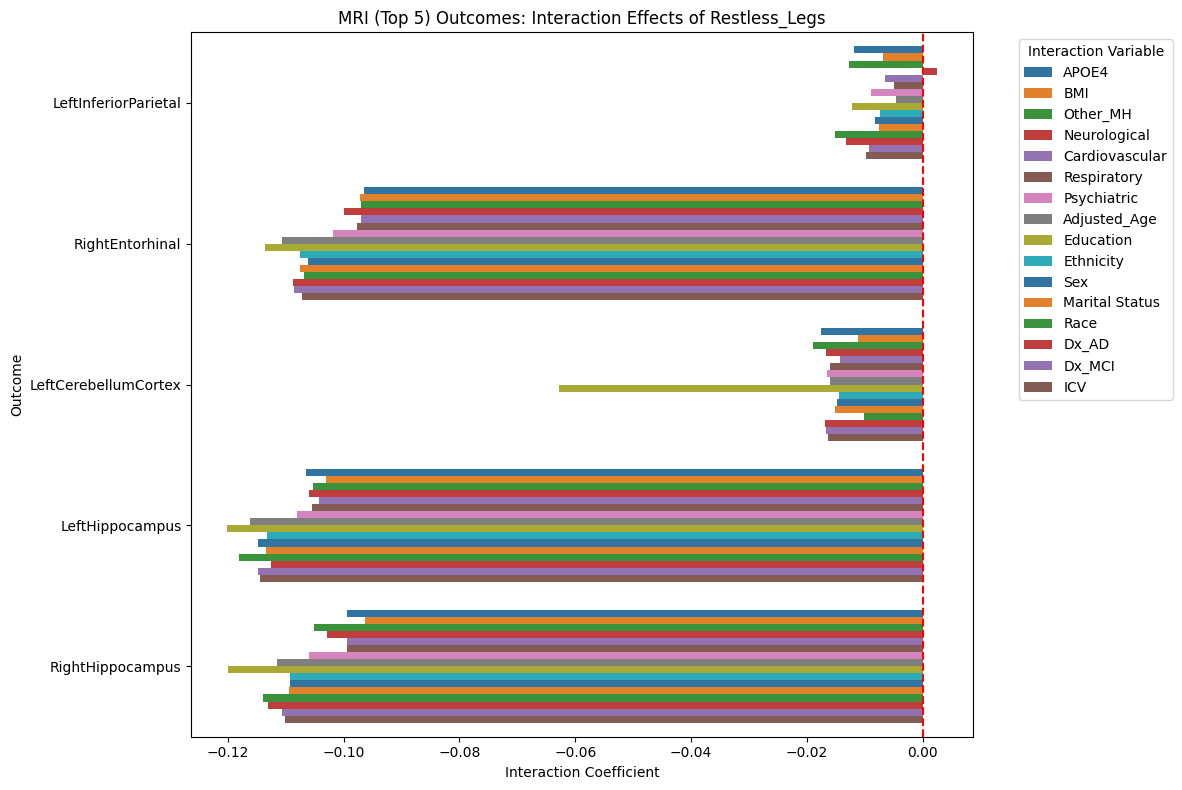

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


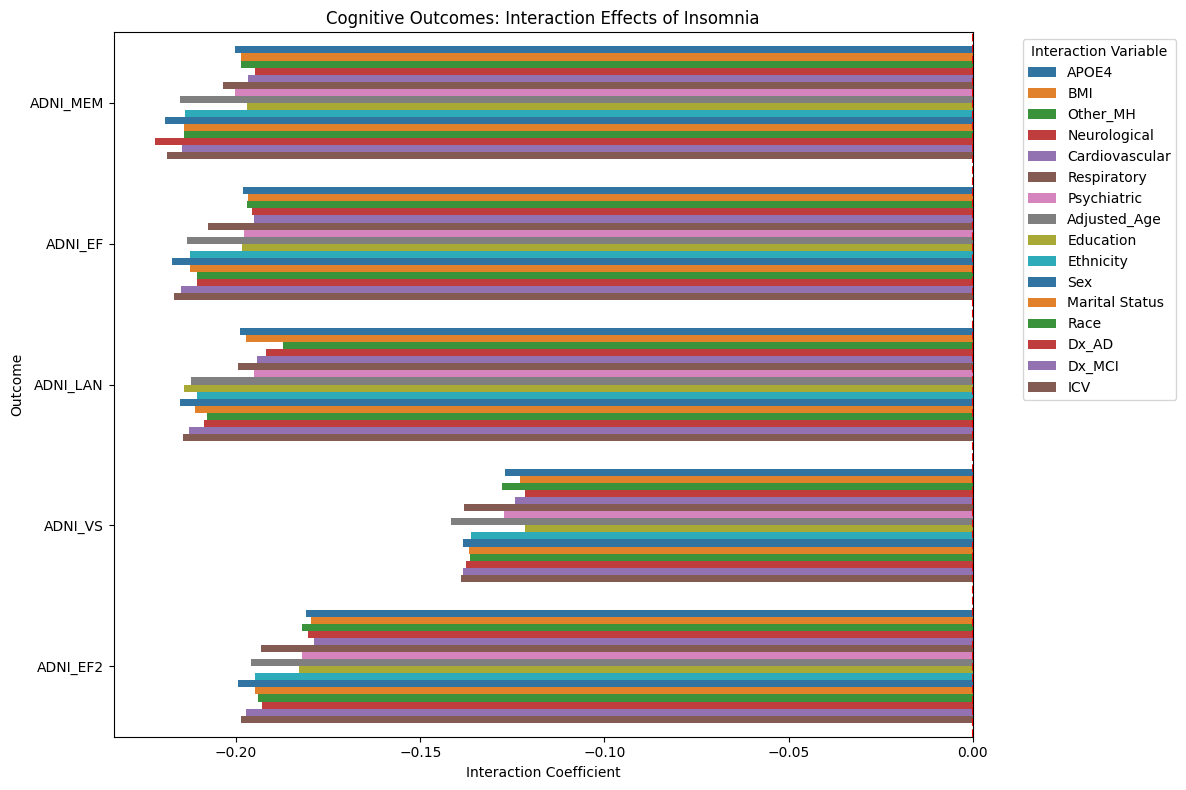

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


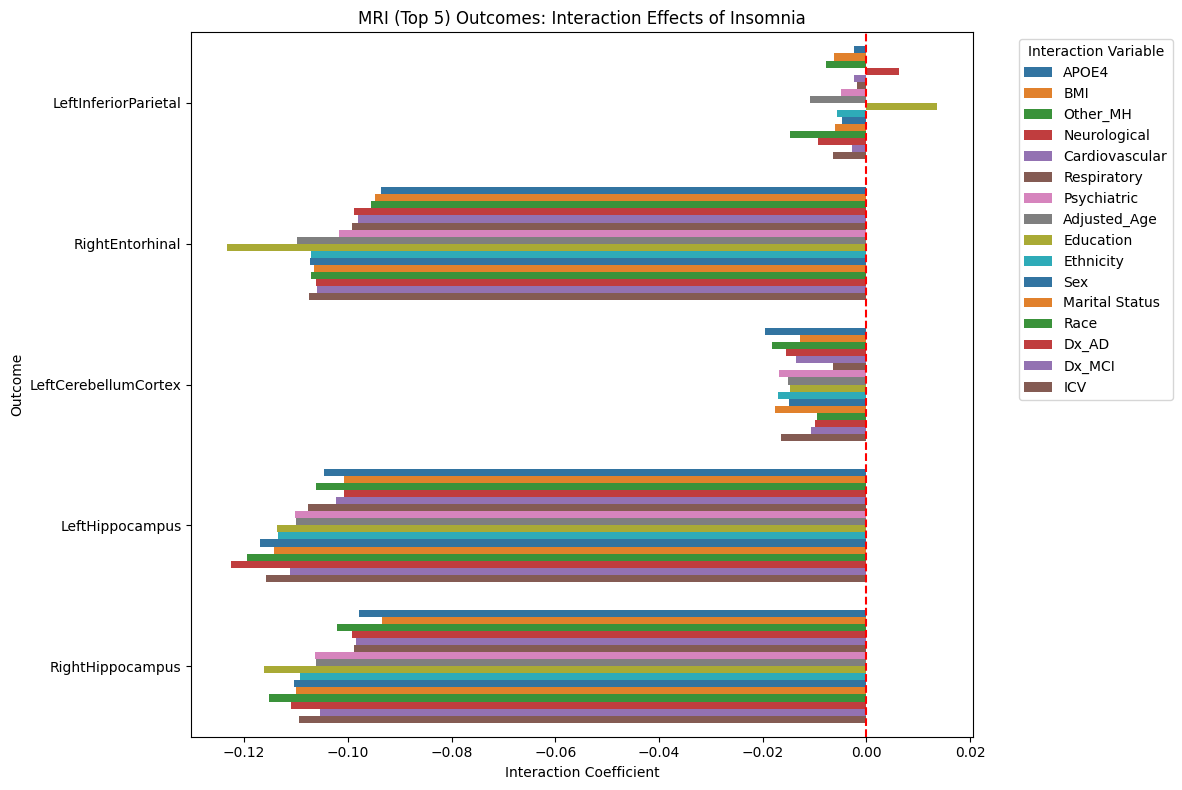

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


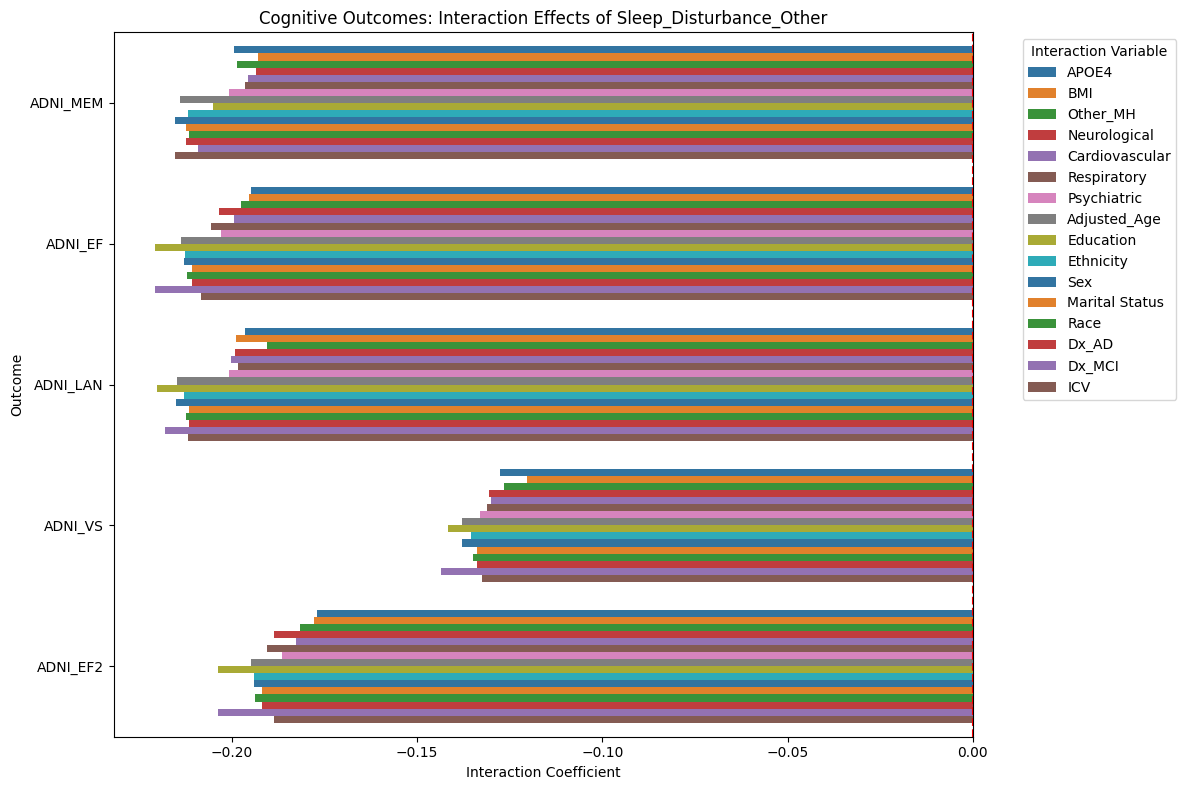

C:\Users\anisr\AppData\Local\Temp\ipykernel_9112\1099752111.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


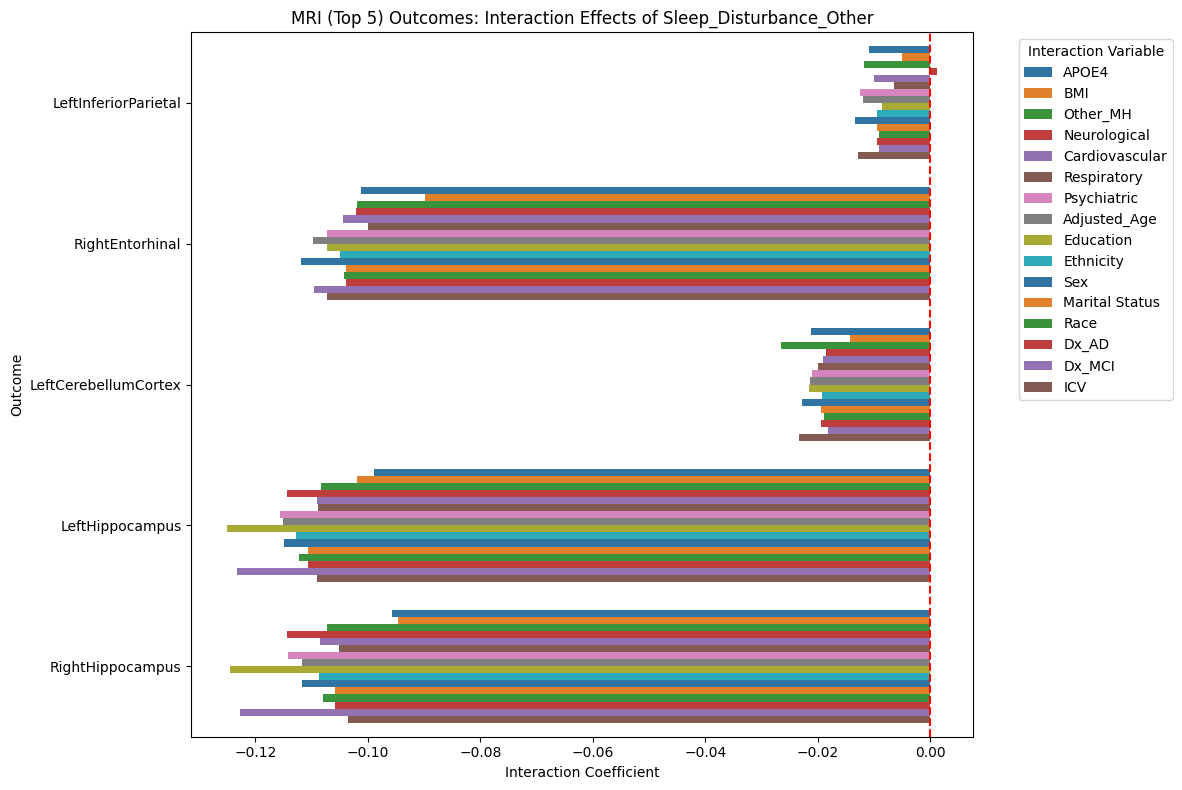

In [62]:
def flatten_interaction_results(results_dict, outcome_type):
    records = []
    for sleep_var, models in results_dict.items():
        for model in models:
            record = {
                'Model_ID': model.get('Model_ID'),
                'Outcome': model.get('Outcome'),
                'Sleep_Variable': model.get('Sleep_Variable'),
                'Interaction_Variable': model.get('Interaction_Variable'),
                'Feature': model.get('Feature'),
                'Coefficient': model.get('Coefficient'),
                'P-Value': model.get('P-Value'),
                'F-Statistic': model.get('F-Statistic'),
                'P-Value (F)': model.get('P-Value (F)'),
                'Type': outcome_type
            }
            records.append(record)
    return pd.DataFrame(records)


flat_cog_interactions = flatten_interaction_results(
    interaction_results['cognitive'], 'Cognitive')
flat_mri_interactions = flatten_interaction_results(
    interaction_results['mri'], 'MRI')

flat_cog_interactions['Feature'] = flat_cog_interactions['Feature'].replace(
    feature_rename_map)
flat_mri_interactions['Feature'] = flat_mri_interactions['Feature'].replace(
    feature_rename_map)
flat_mri_interactions['Interaction_Variable'] = flat_mri_interactions['Interaction_Variable'].replace(
    feature_rename_map)
flat_cog_interactions['Interaction_Variable'] = flat_cog_interactions['Interaction_Variable'].replace(
    feature_rename_map)

def get_top_5_mri_regions(df):
    top_5 = (
        df.loc[df['Type'] == 'MRI']
        .groupby('Outcome')['Coefficient']
        .apply(lambda x: x.abs().max())
        .nlargest(5)
        .index
    )
    return df[df['Outcome'].isin(top_5)]


flat_mri_interactions = get_top_5_mri_regions(flat_mri_interactions)



def plot_interaction_bars(df, sleep_var, outcome_type):
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=df,
        x='Coefficient', y='Outcome', hue='Interaction_Variable', dodge=True,
        palette='tab10', ci=None
    )
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'{outcome_type} Outcomes: Interaction Effects of {sleep_var}')
    plt.xlabel('Interaction Coefficient')
    plt.ylabel('Outcome')
    plt.legend(title='Interaction Variable',
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



for sleep_var in sleep_vars:
    cog_df = flat_cog_interactions[flat_cog_interactions['Sleep_Variable'] == sleep_var]
    mri_df = flat_mri_interactions[flat_mri_interactions['Sleep_Variable'] == sleep_var]

    if not cog_df.empty:
        plot_interaction_bars(cog_df, sleep_var, 'Cognitive')

    if not mri_df.empty:
        plot_interaction_bars(mri_df, sleep_var, 'MRI (Top 5)')

In [65]:
feature_rename_map 

{'DX_1': 'Dx_AD',
 'DX_2': 'Dx_MCI',
 'PTGENDER': 'Sex',
 'PTEDUCAT': 'Education',
 'AGE': 'Age',
 'PTRACCAT': 'Race',
 'PTETHCAT': 'Ethnicity',
 'PTMARRY': 'Marital Status',
 'APOE4': 'APOE4',
 'BMI': 'BMI',
 'MH19OTHR': 'Other_MH',
 'MH2NEURL': 'Neurological',
 'MH4CARD': 'Cardiovascular',
 'MH5RESP': 'Respiratory',
 'MHPSYCH': 'Psychiatric'}

In [66]:
merge_scaled.rename(columns=feature_rename_map, inplace=True)

In [73]:
def interaction_plot(data, sleep_var, interaction_var, outcome, title):
    plt.figure(figsize=(10, 6))
    x = np.linspace(data[sleep_var].min(), data[sleep_var].max(), 100)
    for level in sorted(data[interaction_var].unique()):
        subset = data[data[interaction_var] == level]
        y = np.poly1d(np.polyfit(subset[sleep_var], subset[outcome], 1))(x)
        plt.plot(x, y, label=f'{interaction_var} = {level}')

    plt.xlabel(sleep_var)
    plt.ylabel(outcome)
    plt.title(title)
    plt.legend(title=interaction_var)
    plt.show()

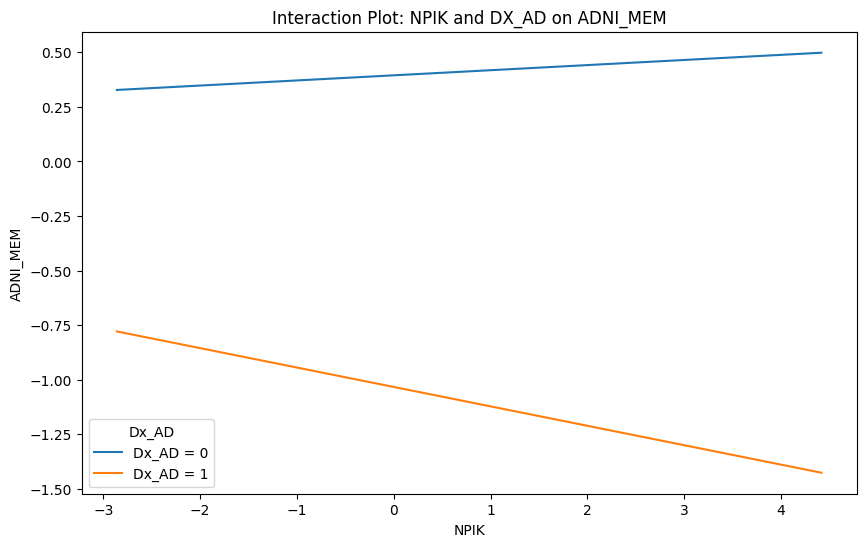

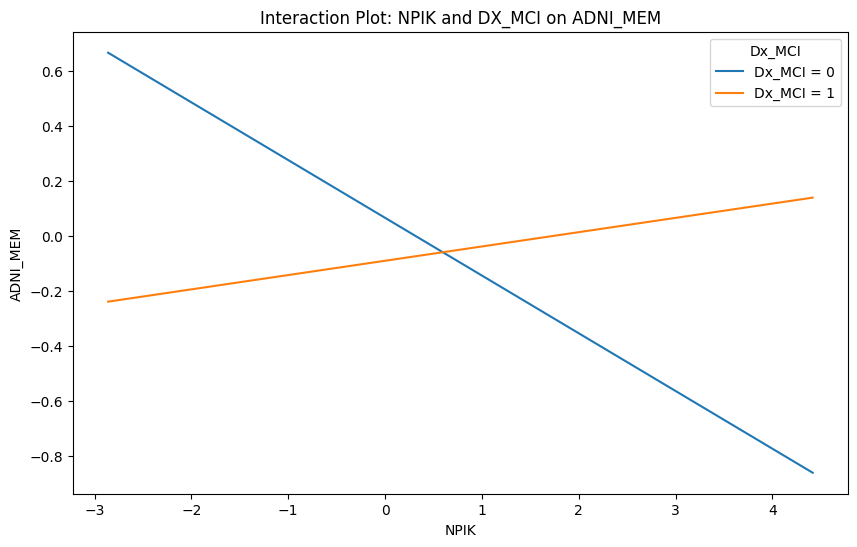

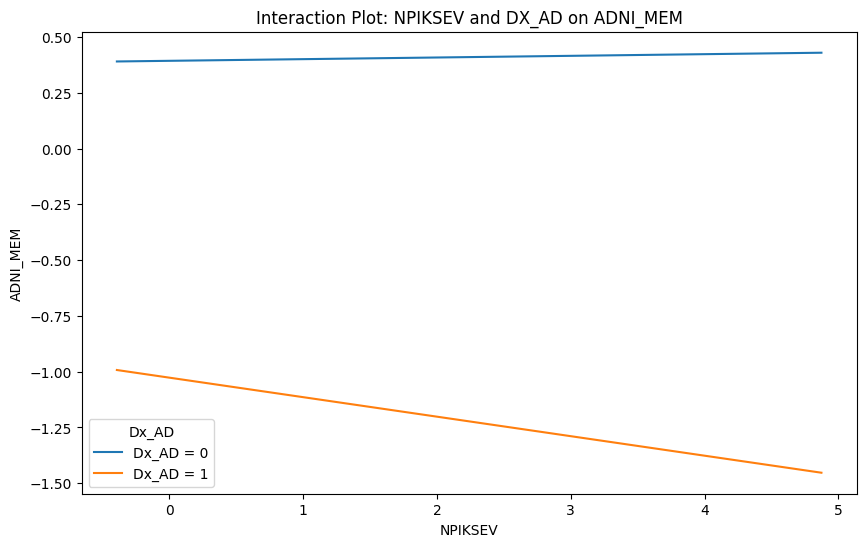

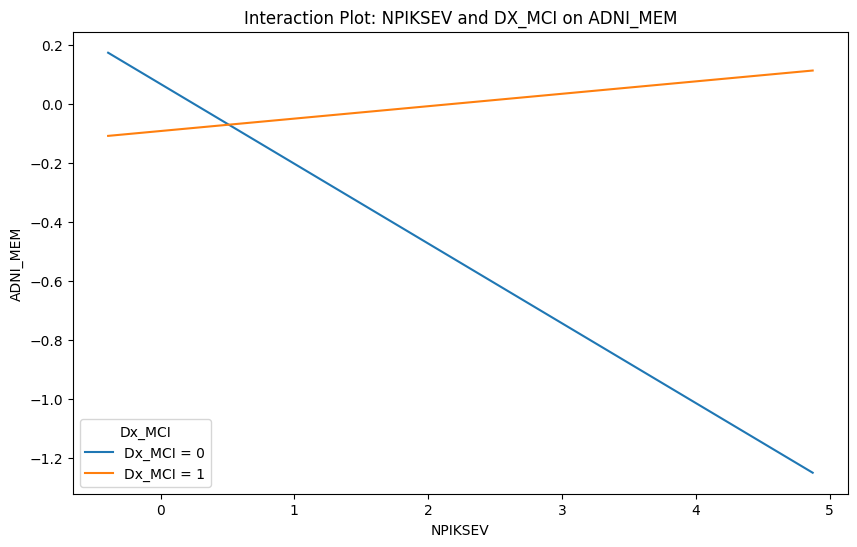

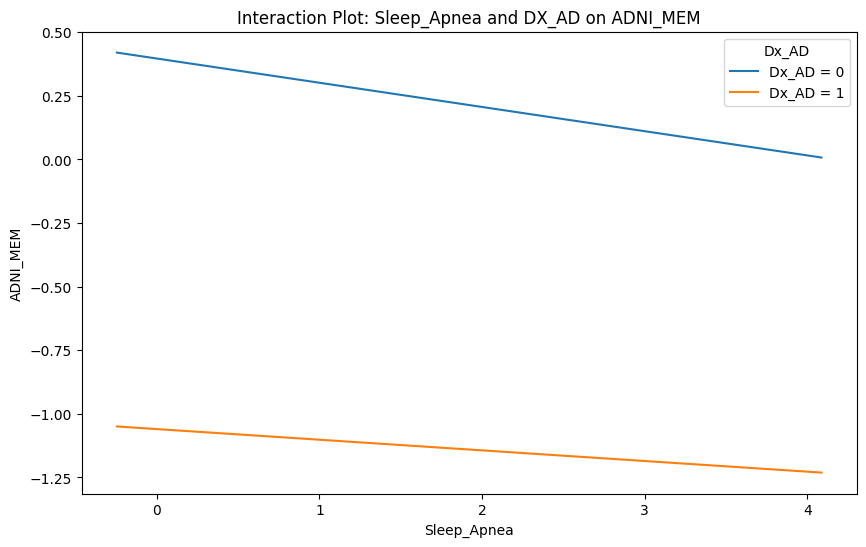

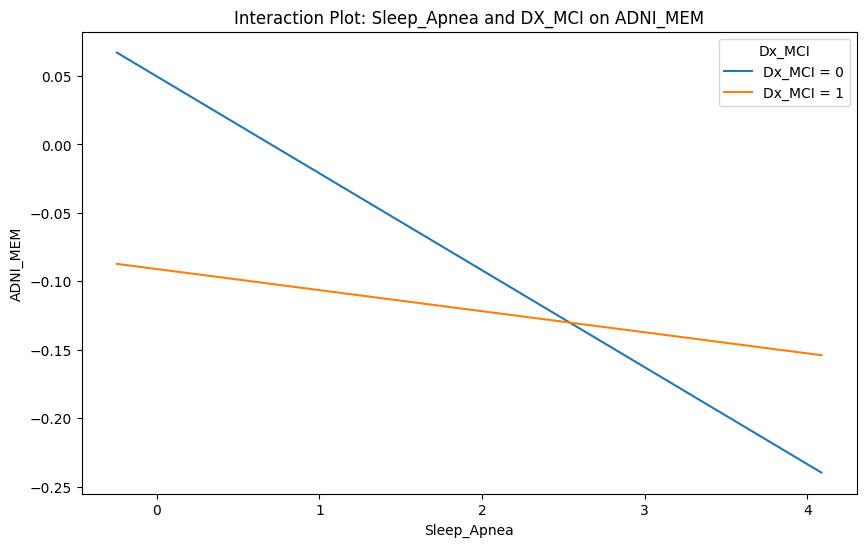

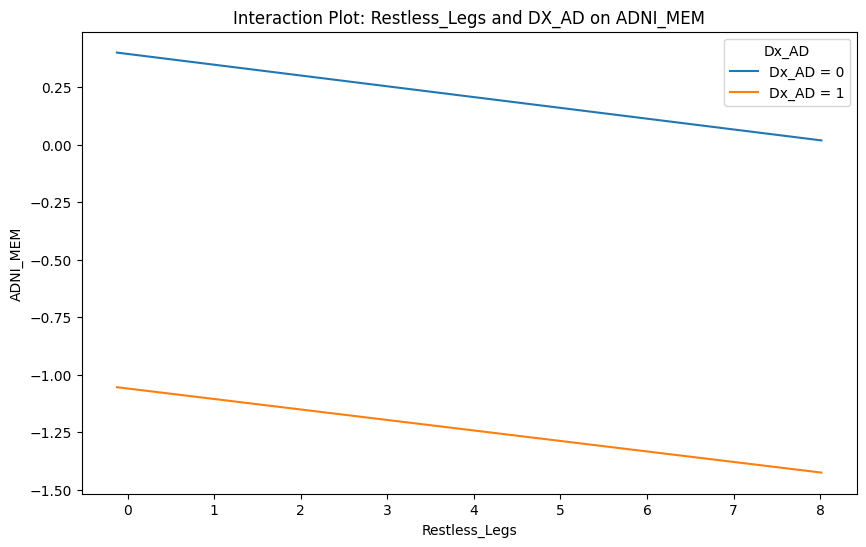

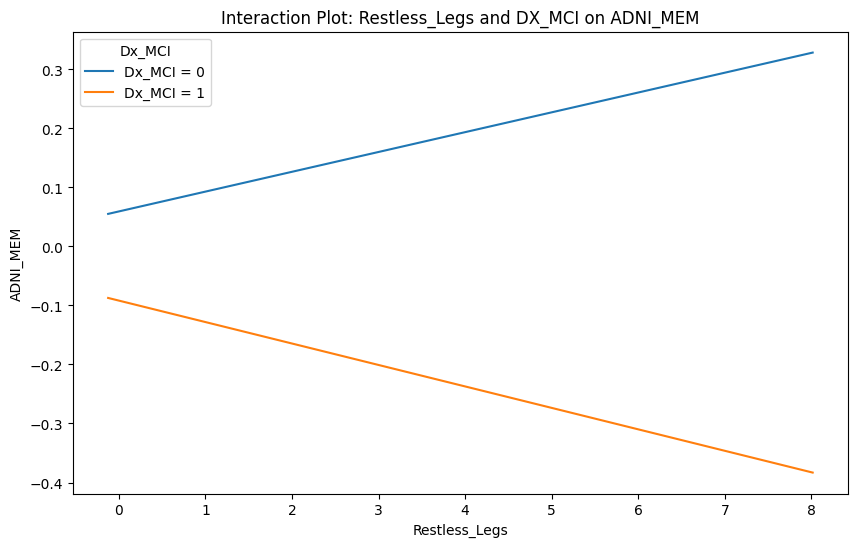

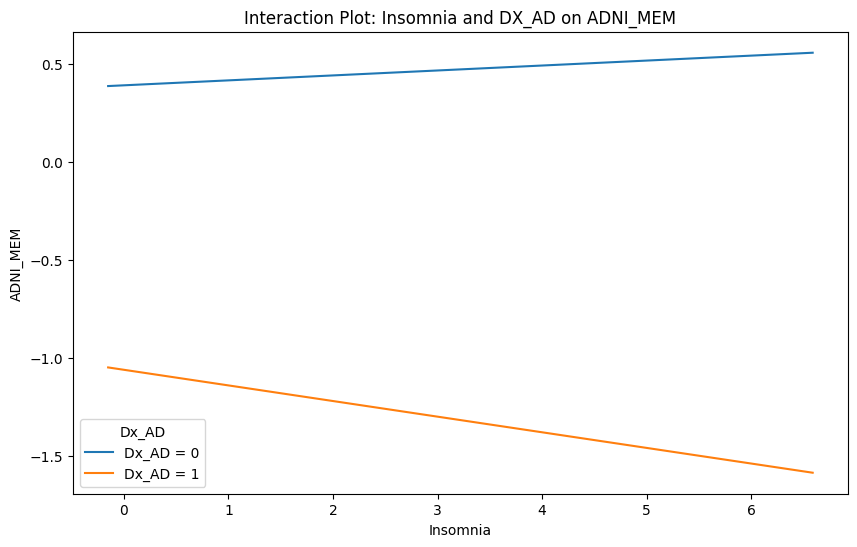

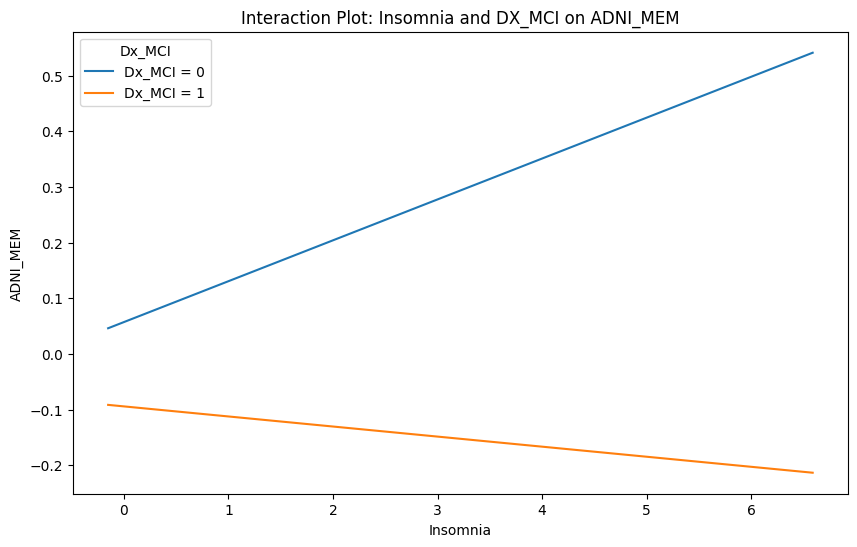

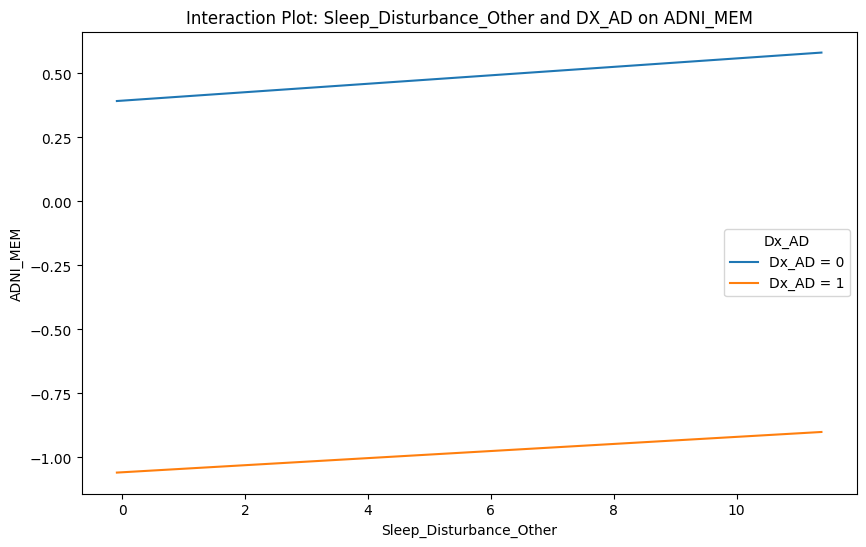

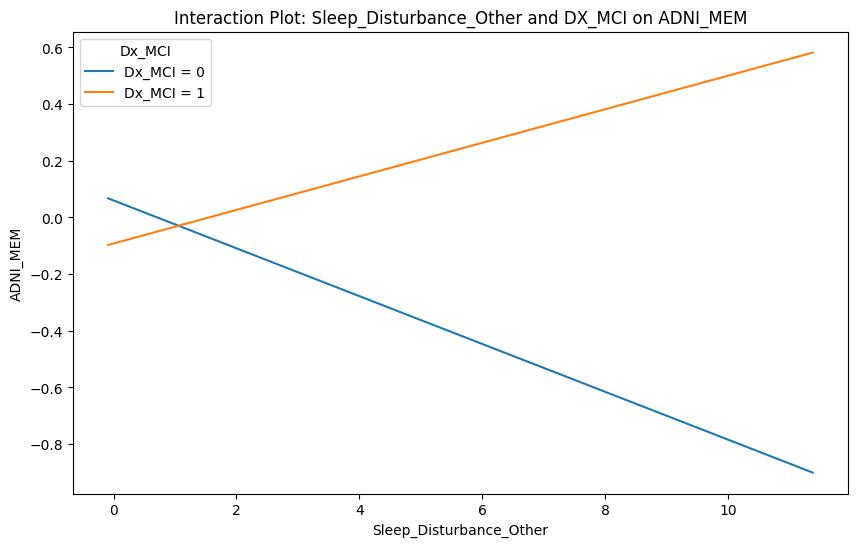

In [72]:
for sleep in sleep_vars:
        interaction_plot(merge_scaled, sleep, 'Dx_AD', "ADNI_MEM",
                         f'Interaction Plot: {sleep} and DX_AD on {"ADNI_MEM"}')
        interaction_plot(merge_scaled, sleep, 'Dx_MCI', "ADNI_MEM",
                         f'Interaction Plot: {sleep} and DX_MCI on {"ADNI_MEM"}')